# Свертка изображений

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from tqdm.notebook import tqdm
from IPython.display import clear_output

## Загрузка изображения

Загрузим любое изображение из интернета. 

In [2]:
# !wget https://raw.githubusercontent.com/hushchyn-mikhail/CourseraDL/main/cnn/screencast_1/butterfly.jpg

## Чтение изображения

In [3]:
# !pip install Pillow

In [4]:
from PIL import Image
img = Image.open("butterfly.jpg")

In [5]:
print(img.format, img.size, img.mode)

JPEG (640, 427) RGB


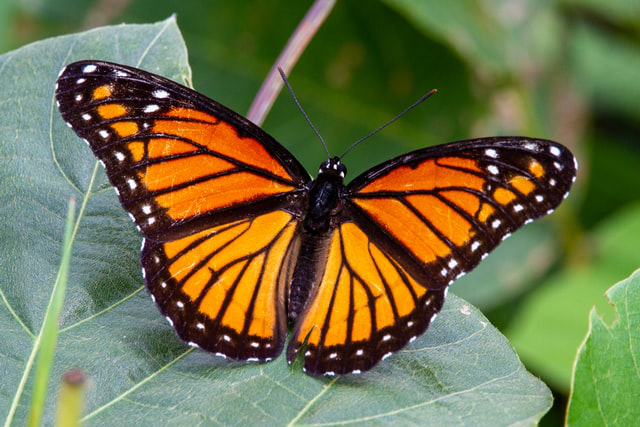

In [6]:
img

## Матричное представление изображения

Мы знаем, что цветное изображение состоит из 3 числовых матриц или трехмерного тензора. Каждая матрица соответствует одному из 3 базовых цветов: красному, зеленому и синему.

In [7]:
# получаем тензор
img_matrix = np.array(img)

#(высота, ширина, каналы)
img_matrix.shape

(427, 640, 3)

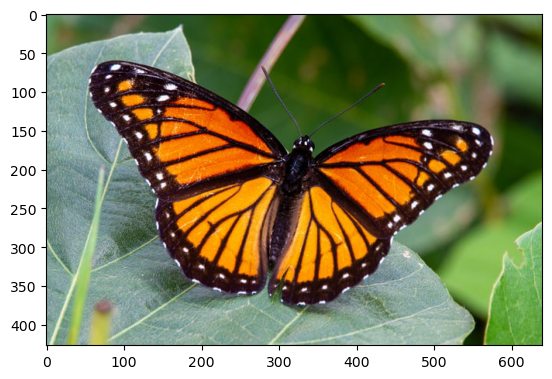

In [8]:
plt.imshow(img_matrix)
plt.show()

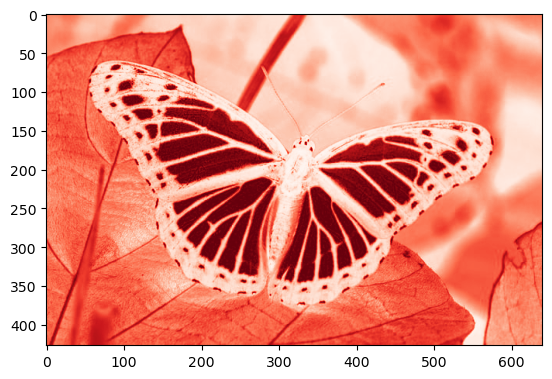

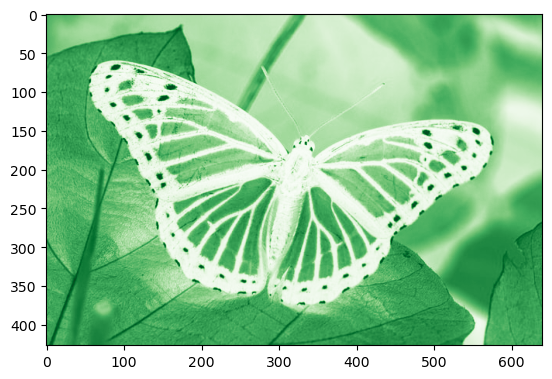

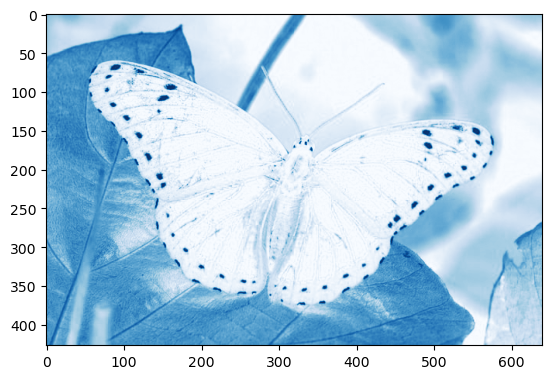

In [9]:
plt.imshow(img_matrix[:, :, 0], cmap=cm.Reds)
plt.show()

plt.imshow(img_matrix[:, :, 1], cmap=cm.Greens)
plt.show()

plt.imshow(img_matrix[:, :, 2], cmap=cm.Blues)
plt.show()

# Операция свертки

В PyTorch свёрточный слой представлен в модуле `nn` функцией [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) с параметрами:
- количество входных каналов `in_channels`
- количество выходных каналов `out_channels`
- размер ядра `kernel_size`
- шаг `stride`
- паддинг `padding`
- режим паддинга `padding_mode` (`'zeros'`, `'reflect'` и др.)
- `dilation`

**Размер ядра** - `int`, если ядро квадратное и кортеж из двух чисел, если ядро прямоугольное. Задает размер фильтра, с которым производится свертка изображения.

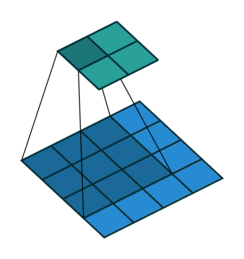
Эта и следующие анимации взяты [здесь](https://github.com/vdumoulin/conv_arithmetic)

**Шаг** - задает шаг, в пикселях, на который сдвигается фильтр. `int`, если по горизонтали и вертикали сдвигается на одно и то же число. Кортеж из двух чисел, если сдвиги разные.

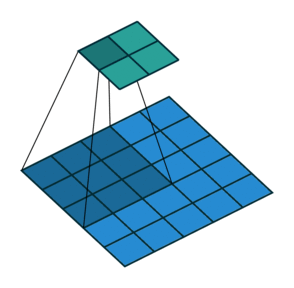
Шаг: 2

**Паддинг** - количество пикселей, которыми дополняется изображение. Аналогично шагу и размеру ядра, может быть, как `int`, так и кортежем из двух чисел.

**Half pading**
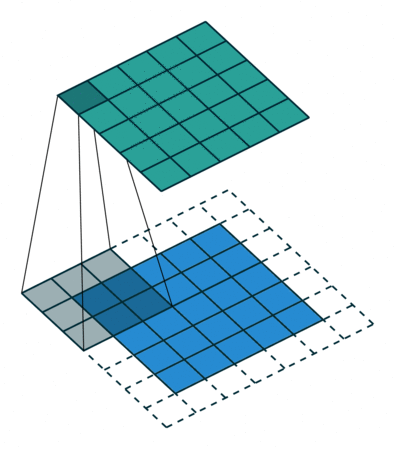

# Свертка изображения

Как работает conv2d:
https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215


Применим оператор Собеля для детектирования границ на изображении.

In [10]:
import torch
from torch.nn.functional import conv2d

Конвертируем изображение в нужный формат для PyTorch

In [11]:
img_tensor = torch.tensor([img_matrix], dtype=torch.float)
img_tensor.size() #(число изображений, высота, ширина, число каналов)

/var/folders/mv/t2n0032d28x_r1br2h8tqzvw0000gn/T/ipykernel_24308/555210499.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1663744309014/work/torch/csrc/utils/tensor_new.cpp:233.)
  img_tensor = torch.tensor([img_matrix], dtype=torch.float)


torch.Size([1, 427, 640, 3])

In [12]:
img_tensor = img_tensor.permute(0, 3, 1, 2)
img_tensor.size() #(число изображений, число каналов, высота, ширина)

torch.Size([1, 3, 427, 640])

Зададим оператор Собеля для детектирования горизонтальных границ

In [13]:
sobel_hor = [[-1, -2, -1], 
             [ 0,  0,  0], 
             [ 1,  2,  1]]

# одна матрица на каждый канал картинки
kernel  = [[sobel_hor, sobel_hor, sobel_hor]]
kernel = torch.tensor(kernel, dtype=torch.float)
kernel.size() #(число выходных каналов, число входных каналов, высота, ширина)

torch.Size([1, 3, 3, 3])

In [14]:
img_conv_hor = conv2d(img_tensor, kernel)

img_conv_hor = img_conv_hor.permute(0, 2, 3, 1)
img_conv_hor.size() #(число изображений, высота, ширина, число каналов)

torch.Size([1, 425, 638, 1])

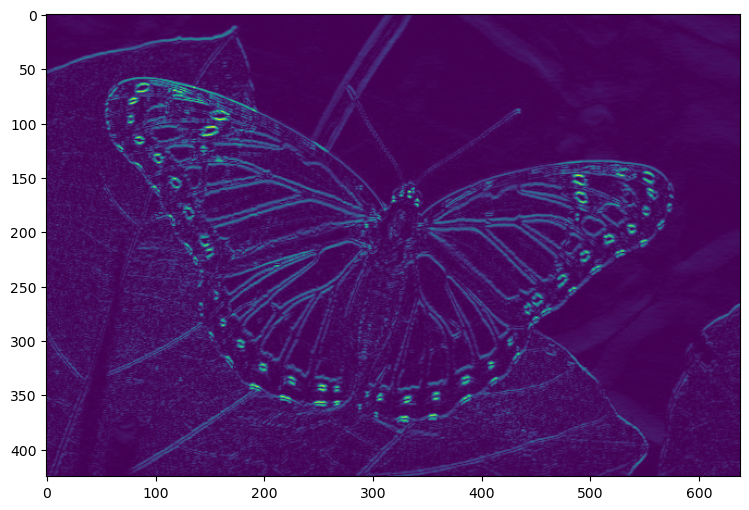

In [15]:
plt.figure(figsize=(1.5*7, 1.5*4))
plt.imshow(torch.abs(img_conv_hor[0, :, :, 0]))
plt.show()

Зададим оператор Собеля для детектирования вертикальных границ

In [16]:
sobel_ver = [[-1, 0, 1], 
             [-2, 0, 2], 
             [-1, 0, 1]]

# одна матрица на каждый канал картинки
kernel  = [[sobel_ver, sobel_ver, sobel_ver]]
kernel = torch.tensor(kernel, dtype=torch.float)
kernel.size() #(число выходных каналов, число входных каналов, высота, ширина)

torch.Size([1, 3, 3, 3])

In [17]:
img_conv_ver = conv2d(img_tensor, kernel)

img_conv_ver = img_conv_ver.permute(0, 2, 3, 1)
img_conv_ver.size() #(число изображений, высота, ширина, число каналов)

torch.Size([1, 425, 638, 1])

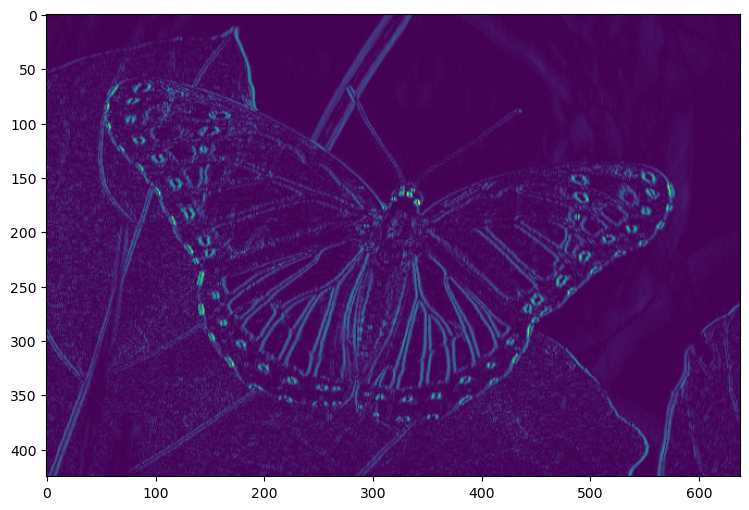

In [18]:
plt.figure(figsize=(1.5*7, 1.5*4))
plt.imshow(torch.abs(img_conv_ver[0, :, :, 0]))
plt.show()

Объединим два изображения

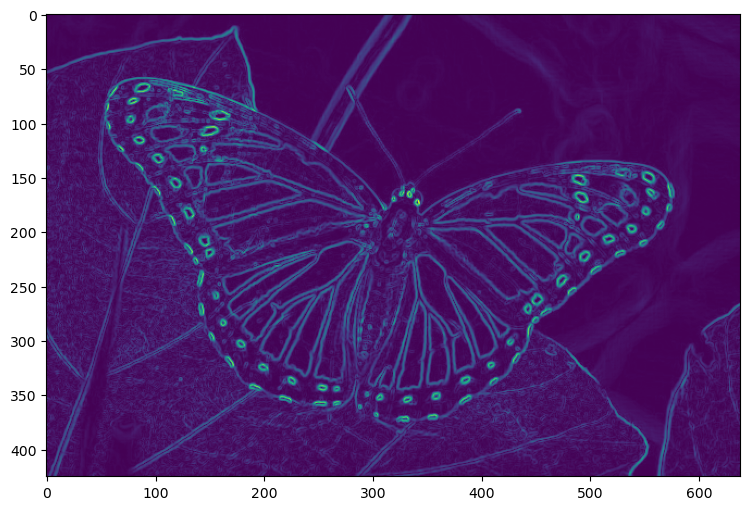

In [19]:
img_conv = torch.sqrt(img_conv_ver**2 + img_conv_hor**2)

plt.figure(figsize=(1.5*7, 1.5*4))
plt.imshow(img_conv[0, :, :, 0])
plt.show()

### Задание 1
По аналогии с примером выше, сверните изображение со случайным ядром такого же размера.

**Подсказка:** используйте `torch.rand()`.

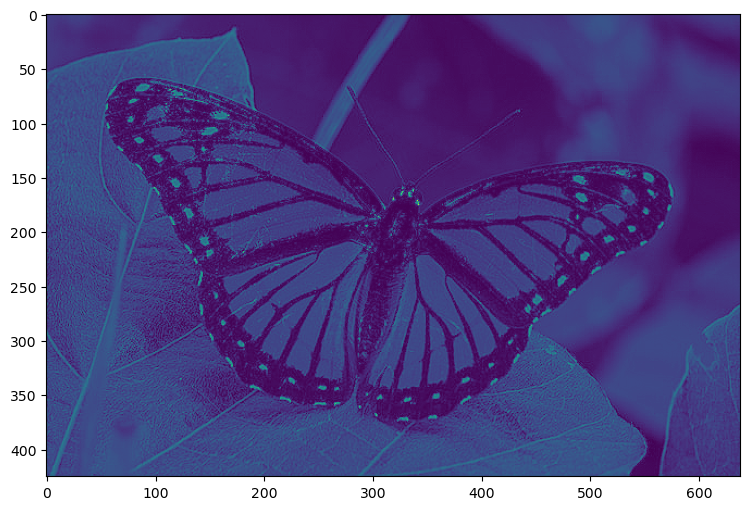

In [20]:
### solution
#kernel = torch.rand((1, 3, 3, 3), dtype=torch.float)
### the end


sharp = [[ 0, -1, 0], 
         [-1, 5, -1], 
         [ 0, -1, 0]]

# одна матрица на каждый канал картинки
kernel  = [[sharp, sharp, sharp]]
kernel = torch.tensor(kernel, dtype=torch.float)


# свертка изображения
img_conv_ver = conv2d(img_tensor, kernel)
img_conv_ver = img_conv_ver.permute(0, 2, 3, 1)

# рисуем результат
plt.figure(figsize=(1.5*7, 1.5*4))
plt.imshow(torch.abs(img_conv_ver[0, :, :, 0]))
plt.show()

# Полносвязная нейронная сеть

Решим задачу классификации изображений полносвзяной нейронной сетью из прошлого семинара.

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

Скачаем и подготовим данные для классификации.

In [22]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,))])

In [23]:
# используем готовый класс от торча для загрузки данных для тренировки
mnist_train = torchvision.datasets.MNIST('./mnist/', train=True, download=True, transform=transform)

# используем готовый класс от торча для загрузки данных для валидации
mnist_val = torchvision.datasets.MNIST('./mnist/', train=False, download=True, transform=transform)

In [24]:
# так как это уже унаследованный от Dataset класс, его можно сразу пихать в даталоадер
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
# так как это уже унаследованный от Dataset класс, его можно сразу пихать в даталоадер
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

Пример изображений

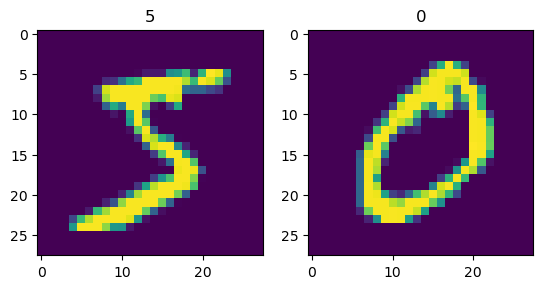

In [25]:
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(mnist_train[i][0].squeeze(0).numpy().reshape([28, 28]))
    plt.title(str(mnist_train[i][1]))
plt.show()

Обучаем полносвязную нейронную сеть для классификации изображений

In [26]:
model = nn.Sequential(
    nn.Flatten(), # превращаем картинку 28х28 в вектор размером 784
    nn.Linear(784, 128), # входной слой размером 784 нейронов с выходом в 128 нейронов
    nn.ReLU(), # функция активации релу
    nn.Linear(128, 10), # функция активации релу
    nn.Softmax(dim=-1) # софтмакс для получения вероятностного распределения над метками класса
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # создаем оптимизатор и передаем туда параметры модели

In [27]:
def train(model, optimizer):
    epoch = 0
    for epoch in range(0,11): # всего у нас будет 10 эпох (10 раз подряд пройдемся по всем батчам из трейна)
        for x_train, y_train in tqdm(train_dataloader): # берем батч из трейн лоадера
            y_pred = model(x_train) # делаем предсказания
            loss = nn.CrossEntropyLoss()(y_pred, y_train) # считаем лосс
            loss.backward() # считаем градиенты обратным проходом
            optimizer.step() # обновляем параметры сети
            optimizer.zero_grad() # обнуляем посчитанные градиенты параметров

        # валидация
        mean_val_loss = [] # сюда будем складывать средний лосс по батчам
        val_accuracy = []
        with torch.no_grad(): # мы считаем качество, поэтому мы запрещаем фреймворку считать градиенты по параметрам
            for x_val, y_val in tqdm(val_dataloader): # берем батч из вал лоадера
                y_pred = model(x_val) # делаем предсказания
                loss = nn.CrossEntropyLoss()(y_pred, y_val) # считаем лосс
                mean_val_loss.append(loss.numpy()) # добавляем в массив 
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
        print('Epoch: {epoch}, loss: {loss}, accuracy: {accuracy}'.format(
                epoch=epoch, loss=np.mean(mean_val_loss), accuracy=np.mean(val_accuracy)
        )) # выводим статистику

In [28]:
train(model, optimizer)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, loss: 1.7978904247283936, accuracy: 0.7293


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 1, loss: 1.6458195447921753, accuracy: 0.8802


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, loss: 1.5972713232040405, accuracy: 0.8985


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 3, loss: 1.580348253250122, accuracy: 0.9075


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, loss: 1.5699844360351562, accuracy: 0.9124


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 5, loss: 1.5629764795303345, accuracy: 0.9166


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 6, loss: 1.5592074394226074, accuracy: 0.9198


  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Сверточный слой

Добавим в нашу сеть сверточный слой. Обратите внимание на то, как изменится качество классификации.

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5), # добавим сверточный слой с 10 ядрами
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),  # уменьшим картинку в 4 раза по каждой стороне
    nn.Flatten(),                 # превращаем картинку 6х6х10 в вектор размером 360
    nn.Linear(6*6*10, 128),       # линейный слой, преобразующий вектор размера 360 в вектор размера 128
    nn.ReLU(),                    # нелинейность
    nn.Linear(128, 10),           # отображение в пространство рамерности числа меток классификации
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
train(model, optimizer)

### Задание 2

По аналогии с предыдущим примером, обучите нейронную сеть, у которой следущие слои:

- Сверточный слой с 10 ядрами размером 5
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)
- Сверточный слой с 20 ядрами размером 5
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)
- Полносвязный слой со 128 нейронами
- Функция активации ReLU
- Выходной слой

In [ ]:
### solution
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),   # добавим сверточный слой с 10 ядрами
    nn.ReLU(),                                                  # нелинейность
    nn.MaxPool2d(kernel_size=2),                                # уменьшим картинку в 2 раза
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5),  # добавим сверточный слой с 20 ядрами
    nn.ReLU(),                   # нелинейность
    nn.MaxPool2d(kernel_size=2), # уменьшим картинку в 2 раза
    nn.Flatten(),                # превращаем картинку 4х4х20 в вектор размером 320
    nn.Linear(4*4*20, 128),      # линейный слой, преобразующий вектор размера 320 в вектор размера 128
    nn.ReLU(),                   # нелинейность
    nn.Linear(128, 10),          # отображение в пространство размерности числа меток классификации
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
train(model, optimizer)